# MSFT Stock Price Presiction using Deep Learning

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load dataset 
data = yf.download('MSFT', start='2015-02-08', end='2025-02-08')
data = data[['Close']]
data.dropna(inplace=True)
# Keep a copy for plotting
data_plot = data.copy()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Check for missing values
print(data.isnull().sum())

Price  Ticker
Close  MSFT      0
dtype: int64


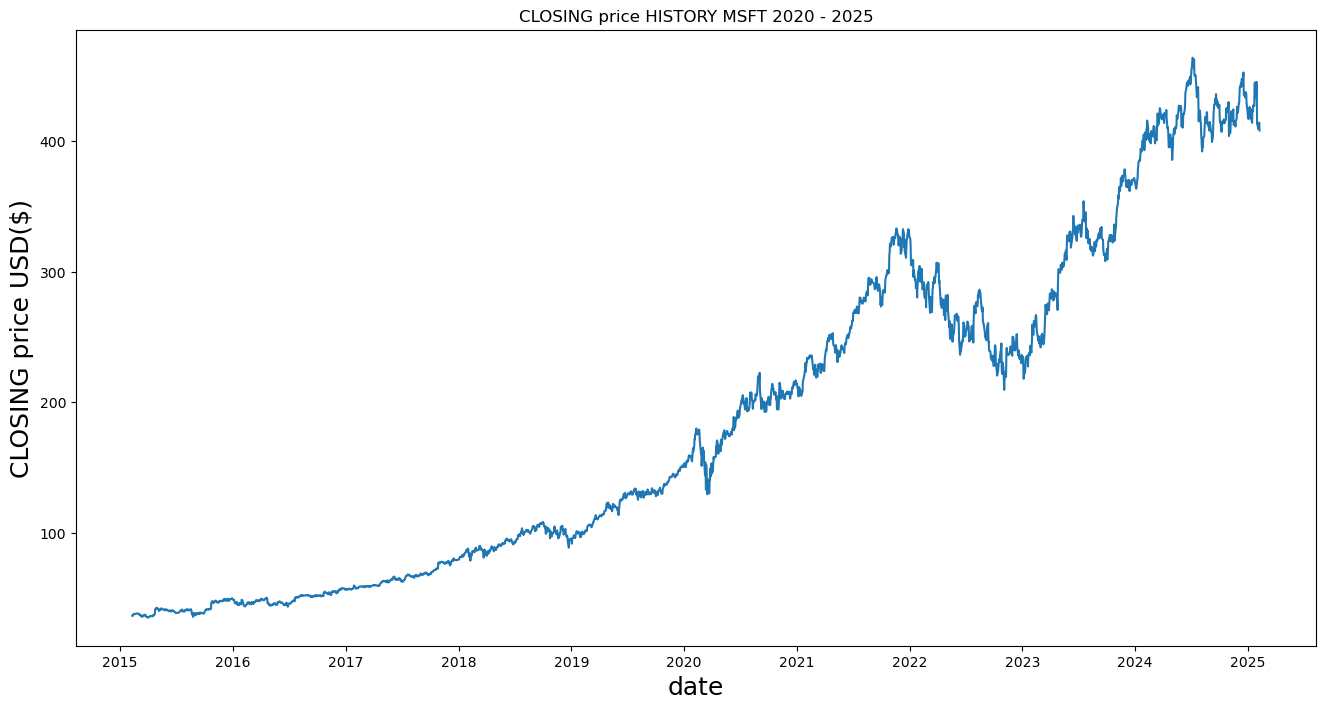

In [5]:
plt.figure(figsize=(16,8))
plt.title('CLOSING price HISTORY MSFT 2020 - 2025')
plt.plot(data['Close'])
plt.xlabel('date',fontsize=18)
plt.ylabel('CLOSING price USD($)',fontsize=18)
plt.show()

### DATA SPLITTING

In [7]:
data = data[['Close']].values
training_data_len = math.ceil(len(data) * 0.8)

In [8]:
train_data = data[:training_data_len]
test_data = data[training_data_len:]

### DATA SCALING

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

### SEQUENCES

In [12]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set time steps (lookback window)
time_steps = 30

# Create training sequences
X_train, y_train = create_sequences(scaled_train_data, time_steps)

# Create test sequences
# Combine last 30 points of training data with test data for proper sequencing
scaled_full_data = np.concatenate([scaled_train_data, scaled_test_data])
X_test, y_test = create_sequences(scaled_full_data[len(scaled_train_data)-time_steps:], time_steps)

### RESHAPE

In [14]:
# Reshape 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (1983, 30, 1)
Test data shape: (503, 30, 1)


## LSTM MODEL

In [16]:
lstm_model = Sequential()

# First LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dropout(0.1))

# Output layer
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 8.4028e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0139
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0077
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.3104e-04
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7991e-04
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.6146e-04
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0044
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.9687e-04
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.4745e-04
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0486e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1

### LSTM PREDICTIONS

In [19]:
# Predict
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
r2 = r2_score(y_test_actual, lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE: 75.7665
R² Score: -0.7783


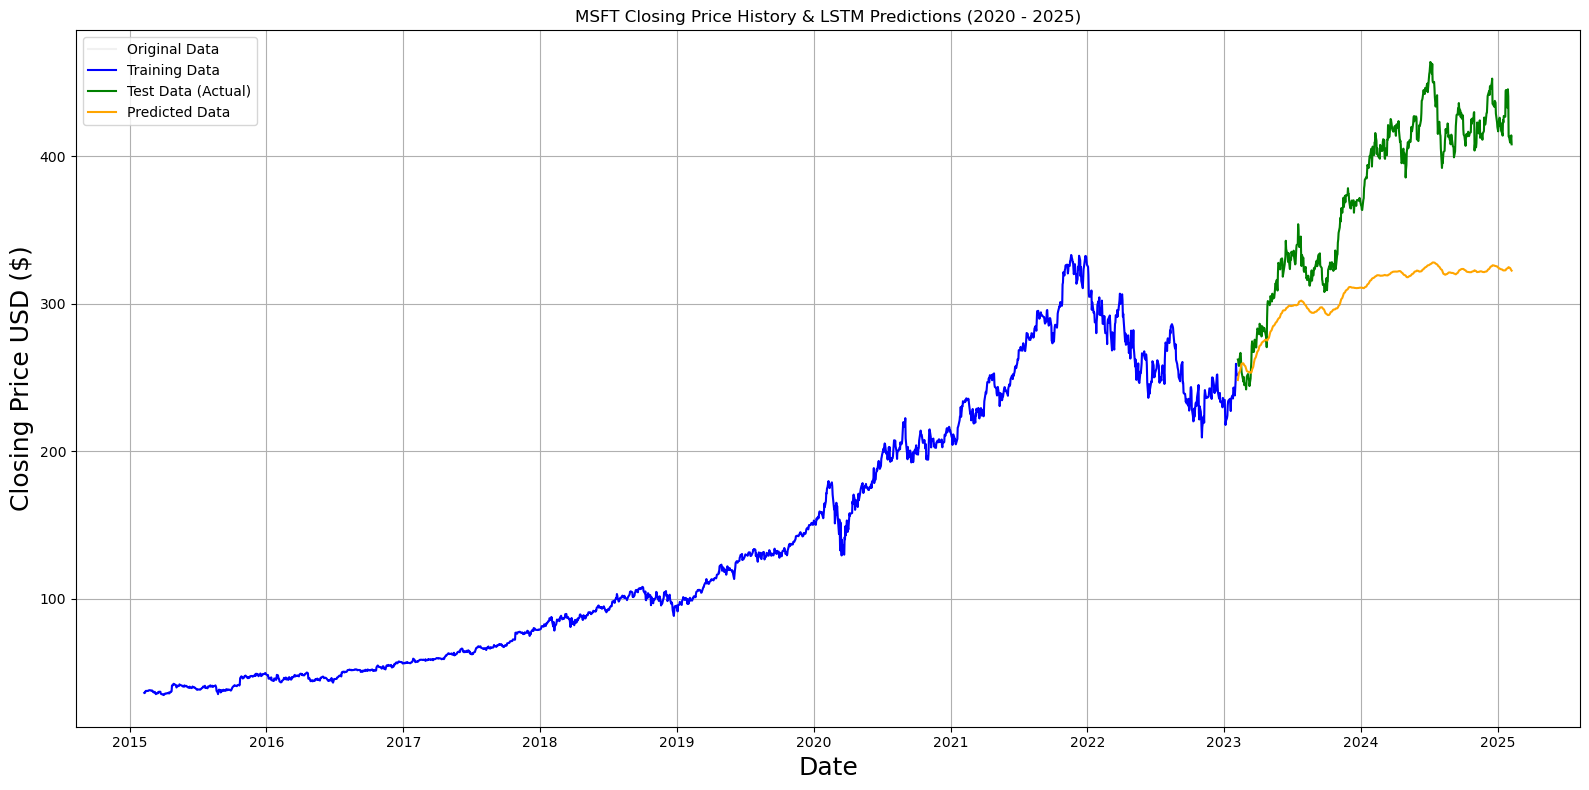

In [20]:
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## GRU MODEL

In [22]:
gru_model = Sequential()

# First GRU layer with dropout
gru_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.1))

# Output layer
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 6.4352e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4970e-04
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.7470e-04
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9760e-04
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0369e-04
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.3992e-04
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3720e-04
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3548e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0192e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━

### GRU PREDICTIONS

In [25]:
# Predict
gru_predictions = gru_model.predict(X_test)

# Inverse transform
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))
r2 = r2_score(y_test_actual, gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")    

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
RMSE: 91.1024
R² Score: -1.5711


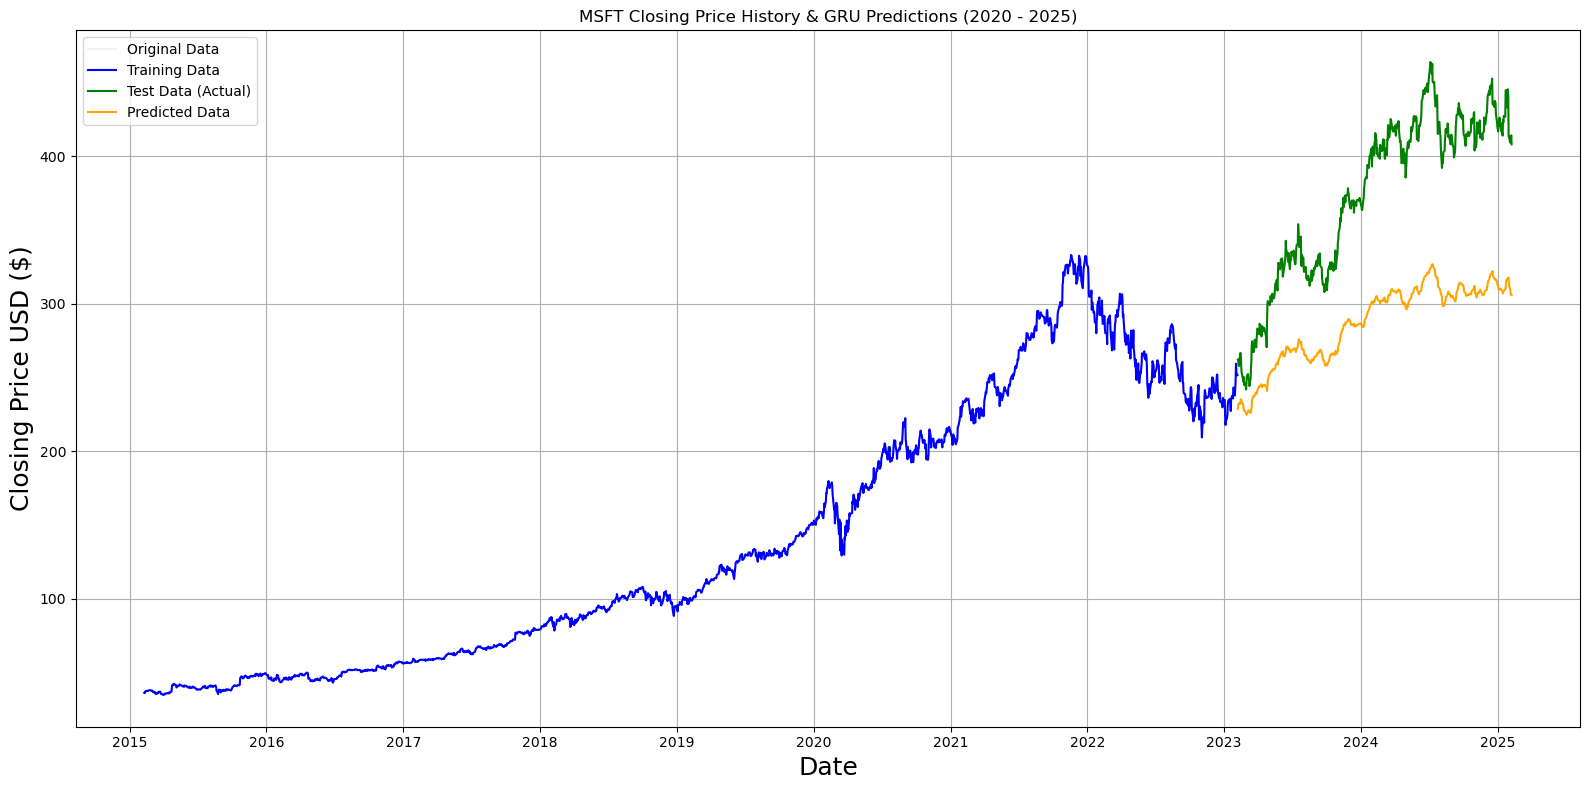

In [26]:
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM-GRU MODEL

In [28]:
lstm_gru_model = Sequential()

# First LSTM layer with dropout
lstm_gru_model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_gru_model.add(Dropout(0.1))

# Second GRU layer with dropout
lstm_gru_model.add(GRU(32, return_sequences=False))
lstm_gru_model.add(Dropout(0.1))

# Output layer
lstm_gru_model.add(Dense(1))

lstm_gru_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_gru_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,721 (41.88 KB)

 Trainable params: 10,721 (41.88 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
lstm_gru_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 7.8805e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0116
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.2212e-04
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0066
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3303e-04
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5551e-04
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.2922e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1114e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/

### LSTM-GRU PREDICTIONS

In [31]:
# Predict
lstm_gru_predictions = lstm_gru_model.predict(X_test)

# Inverse transform
lstm_gru_predictions = scaler.inverse_transform(lstm_gru_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_gru_predictions))
r2 = r2_score(y_test_actual, lstm_gru_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")   

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
RMSE: 120.1439
R² Score: -3.4716


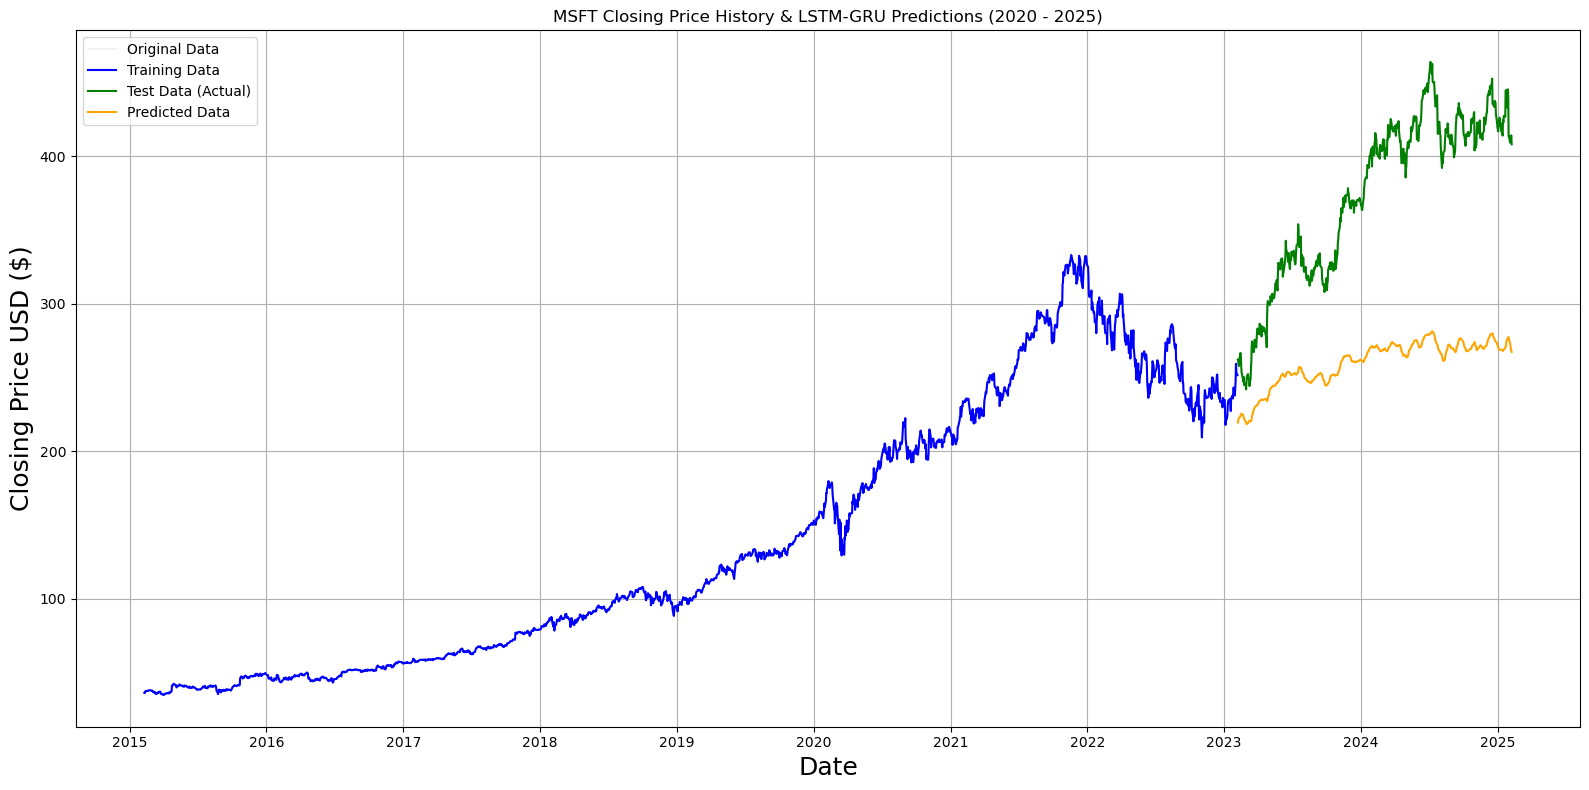

In [32]:
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & LSTM-GRU Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, lstm_gru_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU-LSTM MODEL

In [34]:
gru_lstm_model = Sequential()

# First GRU layer with dropout
gru_lstm_model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_lstm_model.add(Dropout(0.1))

# Second LSTM layer with dropout
gru_lstm_model.add(LSTM(32, return_sequences=False))
gru_lstm_model.add(Dropout(0.1))

# Output layer
gru_lstm_model.add(Dense(1))

gru_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

gru_lstm_model.summary()

C:\Users\TUF\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,713 (45.75 KB)

 Trainable params: 11,713 (45.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gru_lstm_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    verbose=1,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.9148e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0063
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2938e-04
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.7884e-04
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.8386e-04
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 13/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5060e-04
Epoch 14/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.7260e-04
Epoch 15/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/

### GRU-LSTM PREDICTIONS

In [37]:
# Predict
gru_lstm_predictions = gru_lstm_model.predict(X_test)

# Inverse transform
gru_lstm_predictions = scaler.inverse_transform(gru_lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_lstm_predictions))
r2 = r2_score(y_test_actual, gru_lstm_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")  

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
RMSE: 85.1716
R² Score: -1.2472


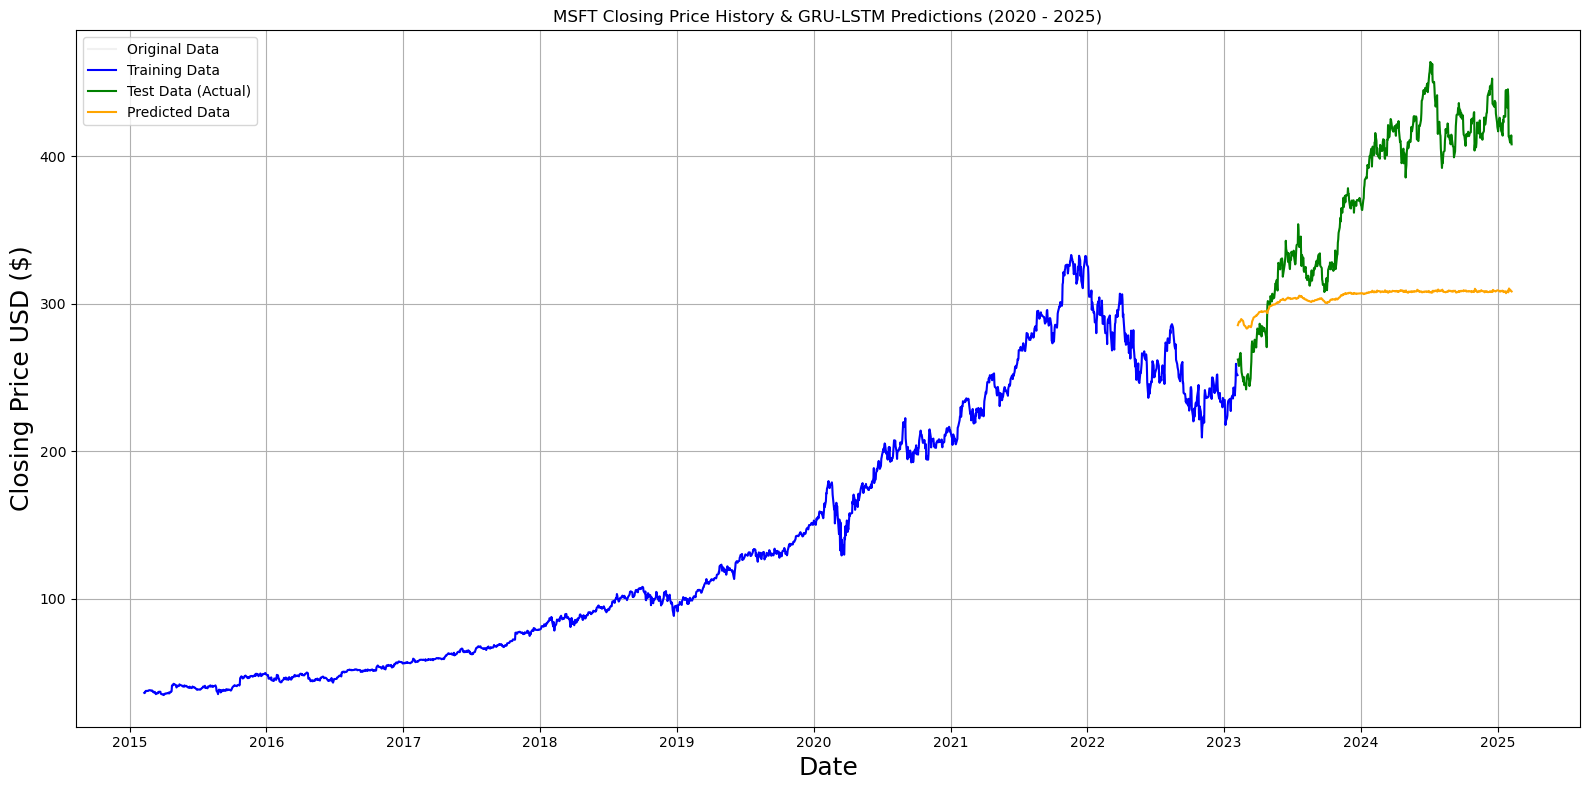

In [38]:
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & GRU-LSTM Predictions (2020 - 2025)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Plot original close prices for visual reference
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Plot training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Plot actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Plot predictions
plt.plot(test_dates, gru_lstm_predictions, label='Predicted Data', color='orange')

# Finalize plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### LSTM TUNING

In [41]:
# ---------------------------
# Define LSTM model builder
# ---------------------------
def build_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:28<23:18, 28.54s/it]

RMSE: 59.3704, R²: -0.0919

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:00<24:19, 30.40s/it]

RMSE: 41.5042, R²: 0.4664

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [02:37<47:52, 61.11s/it]

RMSE: 8.2600, R²: 0.9789

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [03:12<38:55, 50.78s/it]

RMSE: 82.9361, R²: -1.1308

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:38<31:16, 41.69s/it]

RMSE: 56.8418, R²: -0.0009

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:59<25:18, 34.52s/it]

RMSE: 105.2402, R²: -2.4310

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:34<24:53, 34.72s/it]

RMSE: 11.7872, R²: 0.9570

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [05:06<23:45, 33.94s/it]

RMSE: 41.7533, R²: 0.4599

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:36<22:16, 32.60s/it]

RMSE: 10.6133, R²: 0.9651

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:59<19:44, 29.62s/it]

RMSE: 54.4390, R²: 0.0819

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:43<22:17, 34.30s/it]

RMSE: 106.1483, R²: -2.4905

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:13<20:49, 32.87s/it]

RMSE: 127.9376, R²: -4.0706

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:32<17:41, 28.69s/it]

RMSE: 135.5628, R²: -4.6930

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:03<17:33, 29.26s/it]

RMSE: 76.3699, R²: -0.8068

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:27<16:11, 27.76s/it]

RMSE: 103.6988, R²: -2.3312

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [08:51<15:07, 26.70s/it]

RMSE: 14.1530, R²: 0.9379

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:08<13:03, 23.74s/it]

RMSE: 116.0421, R²: -3.1715

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [09:35<13:10, 24.71s/it]

RMSE: 110.8687, R²: -2.8078

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [10:53<20:59, 40.63s/it]

RMSE: 7.9298, R²: 0.9805

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [11:38<21:00, 42.03s/it]

RMSE: 20.4564, R²: 0.8704

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:12<19:05, 39.50s/it]

RMSE: 11.1948, R²: 0.9612

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [12:35<16:06, 34.53s/it]

RMSE: 94.9510, R²: -1.7929

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [13:27<17:57, 39.90s/it]

RMSE: 144.3918, R²: -5.4587

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [14:11<17:50, 41.18s/it]

RMSE: 118.2502, R²: -3.3317

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [14:46<16:25, 39.41s/it]

RMSE: 111.2852, R²: -2.8365

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [15:20<15:01, 37.56s/it]

RMSE: 24.1077, R²: 0.8200

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [15:58<14:29, 37.82s/it]

RMSE: 15.7728, R²: 0.9229

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [16:28<13:00, 35.49s/it]

RMSE: 127.4189, R²: -4.0295

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [17:22<14:21, 41.01s/it]

RMSE: 13.1200, R²: 0.9467

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [17:39<11:16, 33.83s/it]

RMSE: 71.2352, R²: -0.5720

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [18:07<10:09, 32.07s/it]

RMSE: 122.3017, R²: -3.6337

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [18:32<08:57, 29.85s/it]

RMSE: 64.5981, R²: -0.2927

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [19:02<08:31, 30.07s/it]

RMSE: 67.0992, R²: -0.3947

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [19:25<07:24, 27.77s/it]

RMSE: 91.3805, R²: -1.5868

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [19:49<06:38, 26.57s/it]

RMSE: 26.9022, R²: 0.7758

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [20:39<07:50, 33.64s/it]

RMSE: 8.6429, R²: 0.9769

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [21:13<07:20, 33.88s/it]

RMSE: 106.3832, R²: -2.5059

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [21:50<06:55, 34.66s/it]

RMSE: 87.5367, R²: -1.3738

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [22:38<07:06, 38.80s/it]

RMSE: 24.2118, R²: 0.8184

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [23:08<06:01, 36.11s/it]

RMSE: 122.1765, R²: -3.6242

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [23:51<05:43, 38.22s/it]

RMSE: 110.8389, R²: -2.8058

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [24:38<05:26, 40.79s/it]

RMSE: 136.9664, R²: -4.8115

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [25:01<04:07, 35.36s/it]

RMSE: 38.3862, R²: 0.5435

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [25:34<03:29, 34.95s/it]

RMSE: 46.2004, R²: 0.3388

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [26:04<02:46, 33.31s/it]

RMSE: 94.6199, R²: -1.7735

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [26:44<02:21, 35.26s/it]

RMSE: 14.8528, R²: 0.9317

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [27:14<01:41, 33.79s/it]

RMSE: 54.9049, R²: 0.0661

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [27:57<01:12, 36.40s/it]

RMSE: 22.0172, R²: 0.8498

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [28:36<00:37, 37.33s/it]

RMSE: 109.9485, R²: -2.7449

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [30:20<00:00, 36.40s/it]

RMSE: 49.8721, R²: 0.2295

Best Parameters:
validation_split                                                  0.2
units                                                              32
lr                                                              0.001
epochs                                                             50
dropout                                                           0.1
batch_size                                                         16
rmse                                                         7.929841
r2                                                            0.98052
val_loss                                                     0.000771
train_loss                                                   0.000385
preds               [249.8836, 252.64336, 255.23999, 256.9094, 257...
y_true              [262.2317199707031, 261.41827392578125, 258.37...
Name: 18, dtype: object
Best RMSE: 7.9298
Best R²: 0.9805


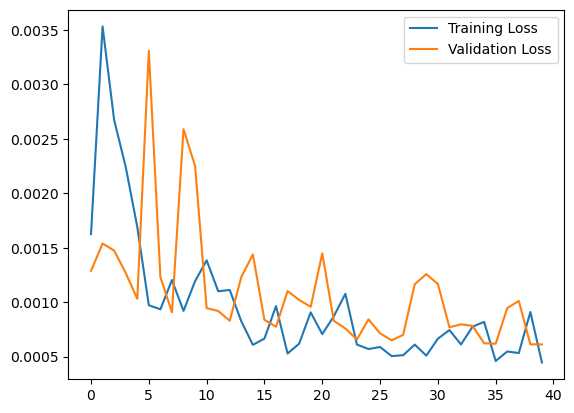

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

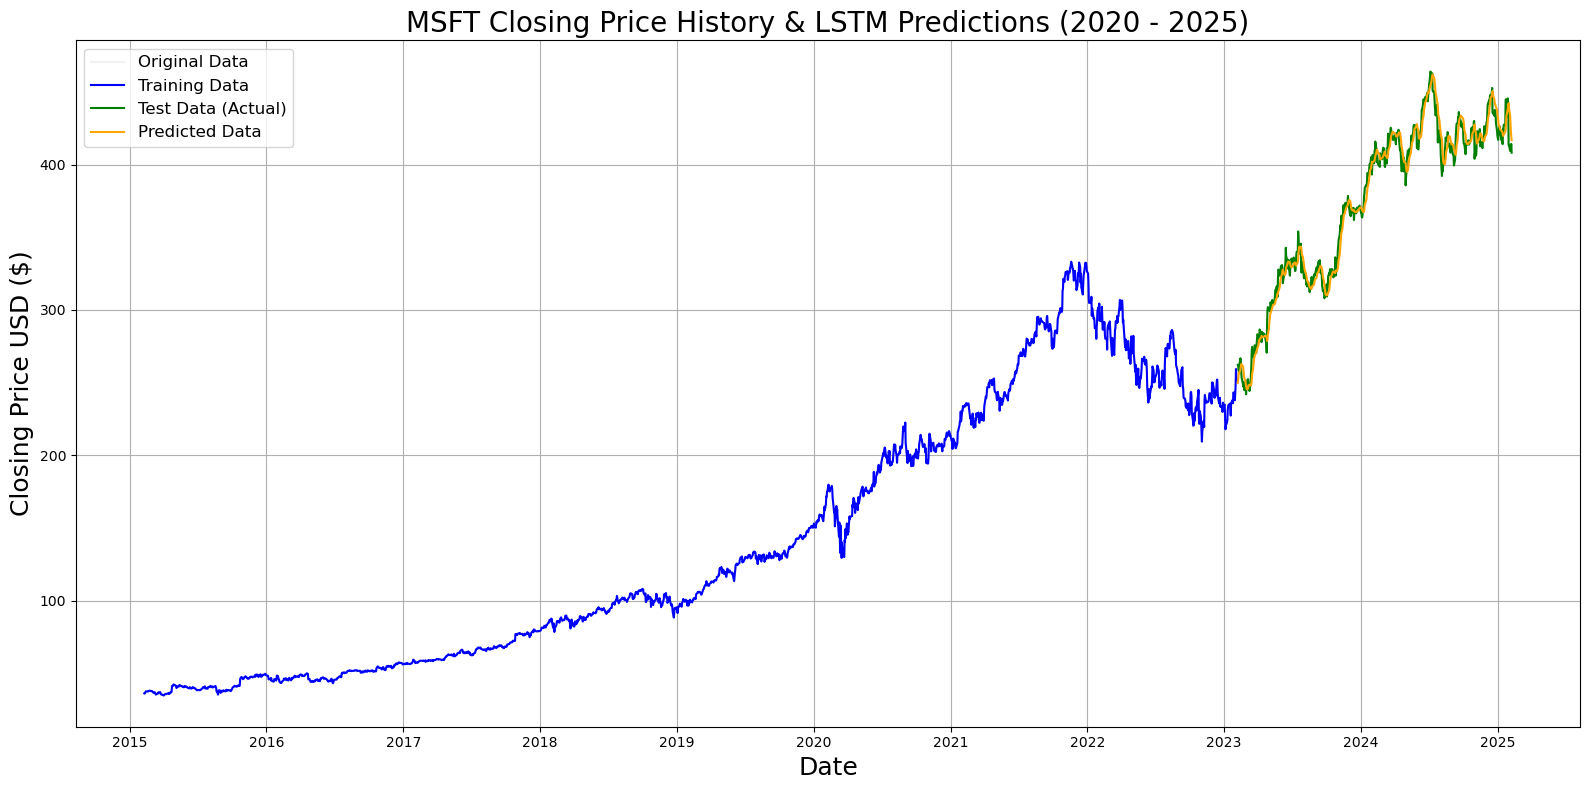

In [43]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### GRU TUNING

In [45]:
# ---------------------------
# Define GRU model builder
# ---------------------------
def build_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:42<34:31, 42.28s/it]

RMSE: 21.4319, R²: 0.8577

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [01:27<35:25, 44.28s/it]

RMSE: 26.7488, R²: 0.7783

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [02:06<32:44, 41.79s/it]

RMSE: 7.4903, R²: 0.9826

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:46<31:19, 40.85s/it]

RMSE: 69.4647, R²: -0.4948

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:20<28:57, 38.62s/it]

RMSE: 15.0083, R²: 0.9302

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:48<25:28, 34.73s/it]

RMSE: 79.9024, R²: -0.9778

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:14<23:03, 32.18s/it]

RMSE: 9.2927, R²: 0.9732

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [05:08<27:14, 38.91s/it]

RMSE: 13.5507, R²: 0.9431

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:35<24:05, 35.27s/it]

RMSE: 10.4404, R²: 0.9662

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [06:08<22:58, 34.46s/it]

RMSE: 17.3497, R²: 0.9068

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:36<21:15, 32.71s/it]

RMSE: 93.6304, R²: -1.7158

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:04<19:43, 31.14s/it]

RMSE: 78.7805, R²: -0.9226

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:25<17:22, 28.16s/it]

RMSE: 104.9994, R²: -2.4153

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:13<20:28, 34.12s/it]

RMSE: 13.9061, R²: 0.9401

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:45<19:32, 33.50s/it]

RMSE: 125.3573, R²: -3.8681

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [09:16<18:32, 32.72s/it]

RMSE: 11.5969, R²: 0.9583

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:36<15:53, 28.91s/it]

RMSE: 68.4085, R²: -0.4497

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [10:07<15:41, 29.43s/it]

RMSE: 90.3392, R²: -1.5282

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [10:55<18:10, 35.17s/it]

RMSE: 8.3154, R²: 0.9786

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:10<23:26, 46.87s/it]

RMSE: 7.9292, R²: 0.9805

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:37<19:54, 41.17s/it]

RMSE: 14.7104, R²: 0.9330

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [12:57<16:12, 34.74s/it]

RMSE: 89.4495, R²: -1.4786

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:09<20:39, 45.90s/it]

RMSE: 139.4290, R²: -5.0223

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:03<20:54, 48.24s/it]

RMSE: 133.1099, R²: -4.4888

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [15:39<18:35, 44.61s/it]

RMSE: 85.1867, R²: -1.2480

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:06<15:43, 39.30s/it]

RMSE: 12.2869, R²: 0.9532

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [16:38<14:17, 37.27s/it]

RMSE: 11.1813, R²: 0.9613

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [17:21<14:17, 38.96s/it]

RMSE: 109.3566, R²: -2.7047

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [18:17<15:25, 44.07s/it]

RMSE: 9.1602, R²: 0.9740

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [18:46<13:08, 39.42s/it]

RMSE: 56.8768, R²: -0.0021

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [20:03<16:04, 50.76s/it]

RMSE: 134.9932, R²: -4.6452

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [20:58<15:35, 52.00s/it]

RMSE: 23.0419, R²: 0.8355

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [21:26<12:41, 44.77s/it]

RMSE: 121.2588, R²: -3.5550

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [21:49<10:11, 38.22s/it]

RMSE: 38.9237, R²: 0.5307

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [22:14<08:32, 34.19s/it]

RMSE: 15.5574, R²: 0.9250

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [22:49<08:05, 34.70s/it]

RMSE: 7.0975, R²: 0.9844

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [23:29<07:49, 36.11s/it]

RMSE: 80.5039, R²: -1.0077

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [24:15<07:49, 39.09s/it]

RMSE: 80.9915, R²: -1.0321

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [25:28<09:01, 49.19s/it]

RMSE: 12.9883, R²: 0.9477

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [26:06<07:38, 45.80s/it]

RMSE: 112.7374, R²: -2.9373

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [26:31<05:56, 39.64s/it]

RMSE: 74.1993, R²: -0.7055

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [27:11<05:17, 39.65s/it]

RMSE: 129.0595, R²: -4.1599

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [27:38<04:12, 36.06s/it]

RMSE: 6.6980, R²: 0.9861

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [28:03<03:15, 32.59s/it]

RMSE: 70.2841, R²: -0.5303

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [28:48<03:02, 36.53s/it]

RMSE: 67.3339, R²: -0.4045

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [29:23<02:23, 35.88s/it]

RMSE: 7.1533, R²: 0.9841

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [30:08<01:56, 38.75s/it]

RMSE: 15.7309, R²: 0.9233

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [30:42<01:14, 37.16s/it]

RMSE: 10.0588, R²: 0.9687

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [31:18<00:36, 36.89s/it]

RMSE: 62.4843, R²: -0.2095

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [32:48<00:00, 39.36s/it]

RMSE: 28.4968, R²: 0.7484

Best Parameters:
validation_split                                                  0.1
units                                                              64
lr                                                              0.001
epochs                                                             40
dropout                                                           0.3
batch_size                                                         64
rmse                                                         6.698022
r2                                                           0.986102
val_loss                                                     0.000872
train_loss                                                   0.002917
preds               [250.37425, 253.64558, 256.3608, 257.30762, 25...
y_true              [262.2317199707031, 261.41827392578125, 258.37...
Name: 42, dtype: object
Best RMSE: 6.6980
Best R²: 0.9861


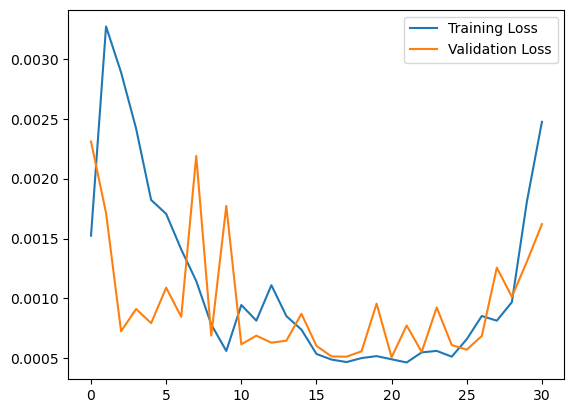

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

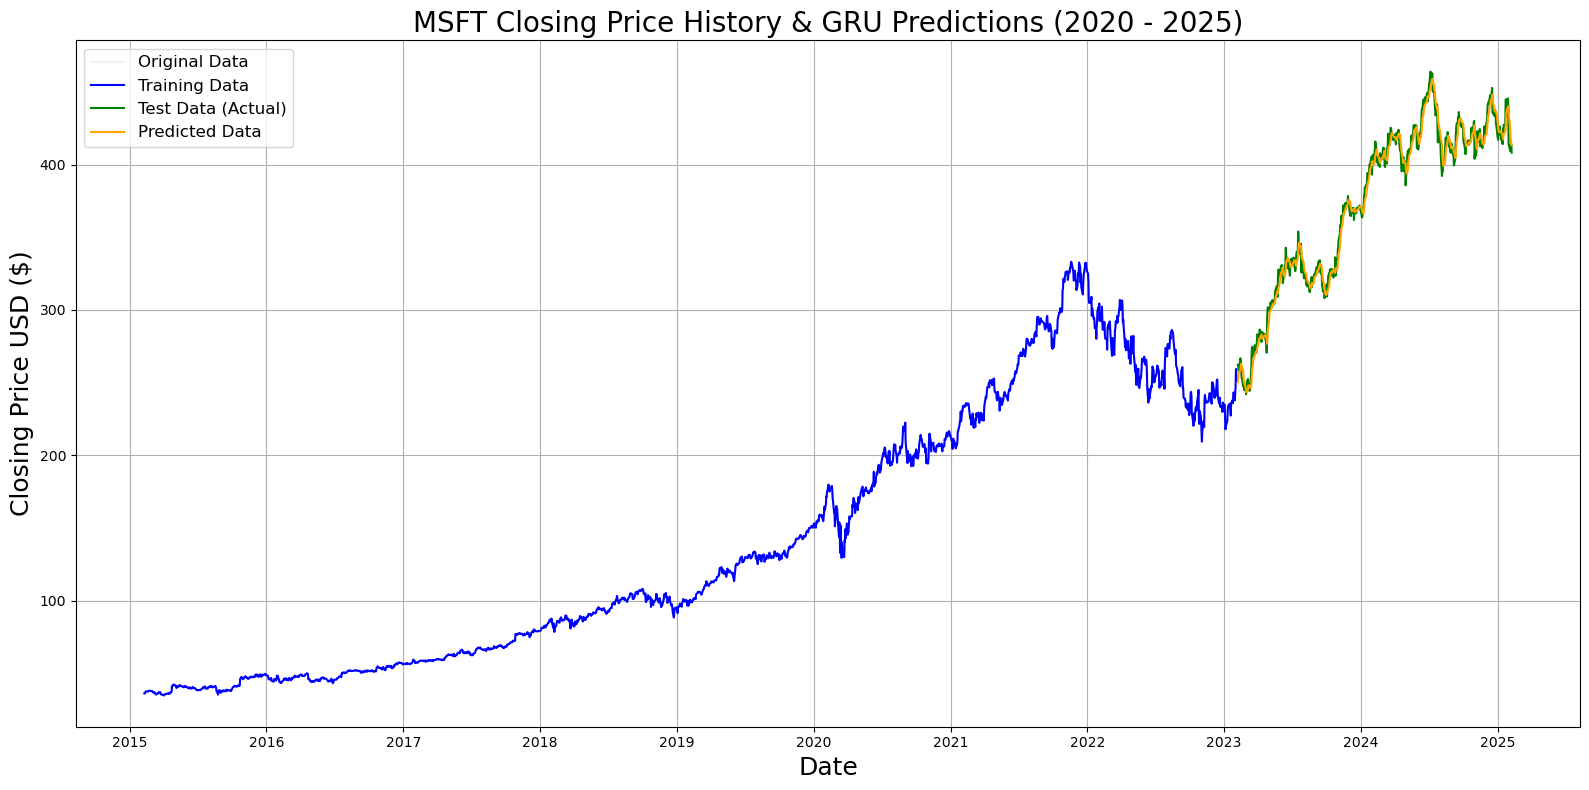

In [47]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID LSTM-GRU

In [49]:
# ---------------------------
# Define LSTM-GRU model builder
# ---------------------------
def build_lstm_gru_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_lstm_gru_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:23<18:54, 23.16s/it]

RMSE: 61.1156, R²: -0.1571

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [00:54<22:28, 28.09s/it]

RMSE: 59.2477, R²: -0.0874

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:49<31:28, 40.18s/it]

RMSE: 11.3509, R²: 0.9601

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:33<32:07, 41.90s/it]

RMSE: 80.0819, R²: -0.9867

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [03:07<29:19, 39.10s/it]

RMSE: 34.2982, R²: 0.6356

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:40<27:00, 36.84s/it]

RMSE: 156.2700, R²: -6.5650

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [04:15<25:59, 36.26s/it]

RMSE: 11.8577, R²: 0.9564

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [04:41<23:08, 33.07s/it]

RMSE: 64.9148, R²: -0.3054

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:16<23:01, 33.71s/it]

RMSE: 13.9433, R²: 0.9398

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:38<19:57, 29.95s/it]

RMSE: 64.8024, R²: -0.3009

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [07:07<31:13, 48.04s/it]

RMSE: 35.8586, R²: 0.6017

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:50<29:27, 46.51s/it]

RMSE: 106.9760, R²: -2.5451

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [08:15<24:43, 40.09s/it]

RMSE: 125.8419, R²: -3.9058

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:41<21:22, 35.62s/it]

RMSE: 42.3058, R²: 0.4456

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [09:05<18:52, 32.36s/it]

RMSE: 135.6993, R²: -4.7045

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [09:32<17:17, 30.51s/it]

RMSE: 19.2424, R²: 0.8853

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:53<15:20, 27.90s/it]

RMSE: 92.8144, R²: -1.6686

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [10:24<15:16, 28.65s/it]

RMSE: 122.2779, R²: -3.6319

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [11:21<19:10, 37.10s/it]

RMSE: 11.5150, R²: 0.9589

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:03<19:17, 38.59s/it]

RMSE: 20.8195, R²: 0.8657

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [12:41<18:38, 38.56s/it]

RMSE: 11.8505, R²: 0.9565

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:09<16:29, 35.33s/it]

RMSE: 144.5884, R²: -5.4763

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:00<18:02, 40.09s/it]

RMSE: 134.1983, R²: -4.5790

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [14:43<17:46, 41.03s/it]

RMSE: 135.0692, R²: -4.6516

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [15:20<16:35, 39.82s/it]

RMSE: 72.8493, R²: -0.6440

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [16:05<16:33, 41.42s/it]

RMSE: 18.6161, R²: 0.8926

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [16:56<16:57, 44.24s/it]

RMSE: 14.9930, R²: 0.9304

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [17:36<15:43, 42.87s/it]

RMSE: 120.1709, R²: -3.4736

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [18:51<18:24, 52.62s/it]

RMSE: 11.5823, R²: 0.9584

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [19:14<14:33, 43.67s/it]

RMSE: 23.0289, R²: 0.8357

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [20:30<16:55, 53.44s/it]

RMSE: 137.4691, R²: -4.8542

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [21:01<13:56, 46.49s/it]

RMSE: 46.5654, R²: 0.3283

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [21:33<11:56, 42.17s/it]

RMSE: 38.0074, R²: 0.5525

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [21:54<09:33, 35.87s/it]

RMSE: 88.7502, R²: -1.4400

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [22:15<07:52, 31.50s/it]

RMSE: 24.7079, R²: 0.8109

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [22:56<07:58, 34.18s/it]

RMSE: 9.2023, R²: 0.9738

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [23:26<07:08, 32.94s/it]

RMSE: 74.1104, R²: -0.7014

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [24:01<06:42, 33.51s/it]

RMSE: 96.9170, R²: -1.9098

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [24:49<06:57, 37.96s/it]

RMSE: 13.7827, R²: 0.9412

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [25:38<06:52, 41.23s/it]

RMSE: 107.6822, R²: -2.5921

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [26:06<05:35, 37.25s/it]

RMSE: 101.5470, R²: -2.1944

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [26:52<05:19, 39.95s/it]

RMSE: 139.6667, R²: -5.0429

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [27:36<04:48, 41.16s/it]

RMSE: 11.9855, R²: 0.9555

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [27:58<03:32, 35.47s/it]

RMSE: 74.1978, R²: -0.7055

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [28:32<02:54, 34.94s/it]

RMSE: 92.1923, R²: -1.6330

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [29:00<02:11, 32.91s/it]

RMSE: 11.9124, R²: 0.9560

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [29:57<02:00, 40.11s/it]

RMSE: 56.7953, R²: 0.0007

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [30:24<01:12, 36.36s/it]

RMSE: 9.1948, R²: 0.9738

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [31:04<00:37, 37.45s/it]

RMSE: 79.6086, R²: -0.9633

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [31:59<00:00, 38.39s/it]

RMSE: 10.9341, R²: 0.9630

Best Parameters:
validation_split                                                  0.1
units                                                              64
lr                                                              0.001
epochs                                                             30
dropout                                                           0.3
batch_size                                                         64
rmse                                                         9.194751
r2                                                            0.97381
val_loss                                                     0.001069
train_loss                                                   0.019168
preds               [245.26874, 247.79655, 250.2858, 252.1796, 253...
y_true              [262.2317199707031, 261.41827392578125, 258.37...
Name: 47, dtype: object
Best RMSE: 9.1948
Best R²: 0.9738


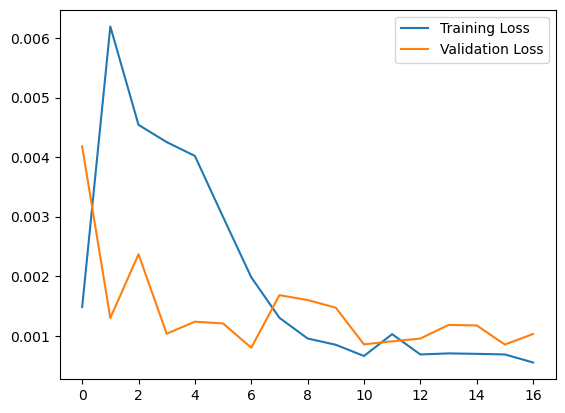

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

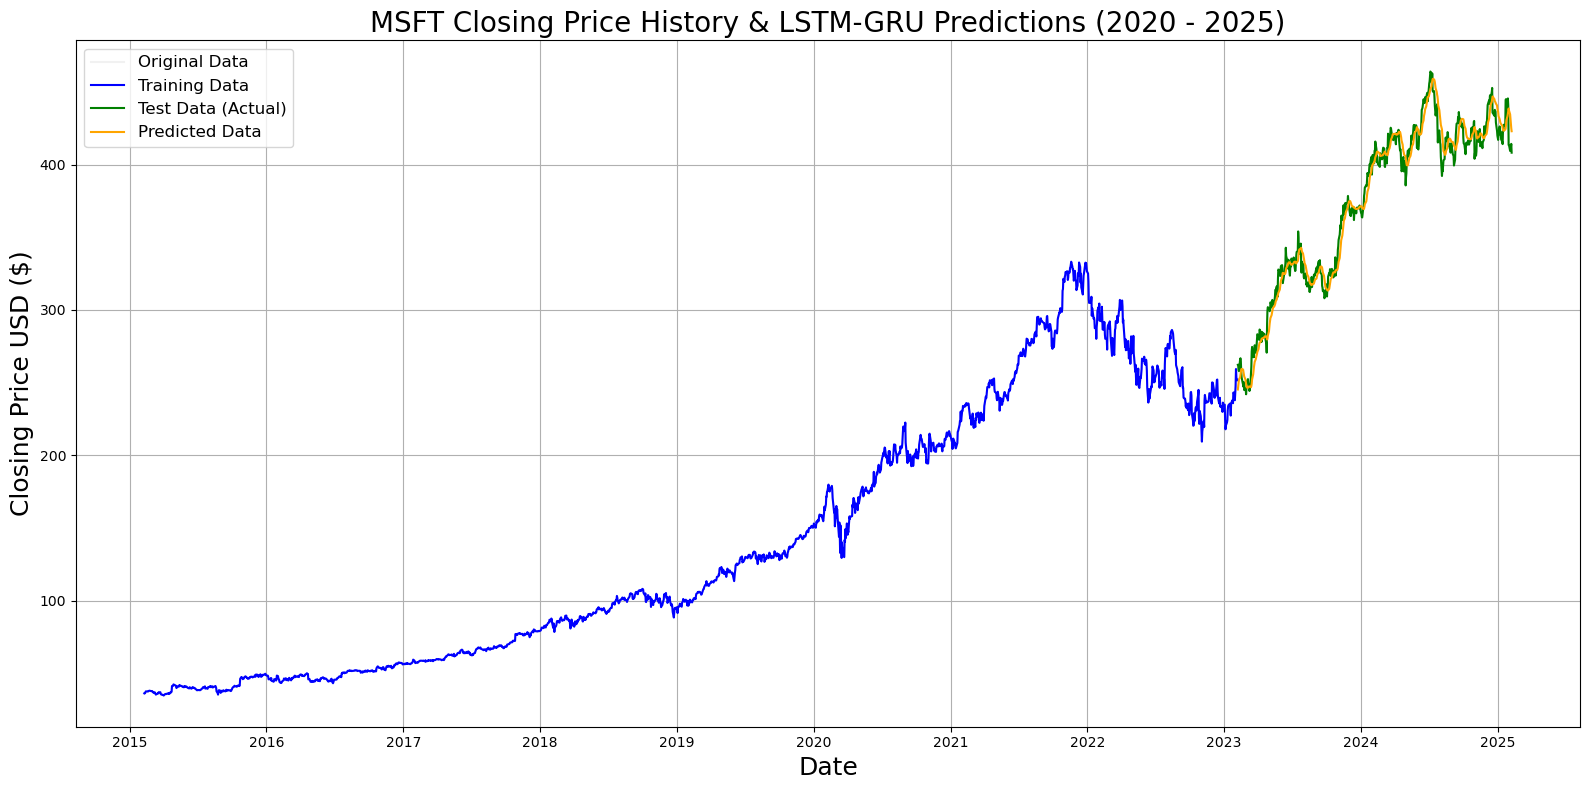

In [51]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & LSTM-GRU Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### HYBRID GRU-LSTM

In [53]:
# ---------------------------
# Define GRU-LSTM model builder
# ---------------------------
def build_gru_lstm_model(units=64, dropout=0.1, lr=0.001, input_shape=(60, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ---------------------------
# Parameter Grid
# ---------------------------
param_grid = {
    'units': [32, 50, 64],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [30, 40, 50],
    'validation_split': [0.1, 0.2]
}

n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
results = []

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=0 
)

# ---------------------------
# Loop through combinations
# ---------------------------
for i, params in enumerate(tqdm(param_list, desc="Random Search Progress")):
    print(f"\nTrial {i+1}/{n_iter}: {params}")
    
    model = build_gru_lstm_model(
        units=params['units'],
        dropout=params['dropout'],
        lr=params['lr'],
        input_shape=(X_train.shape[1], X_train.shape[2])
    )

    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=params['validation_split'],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping_callback]
    )

    # Predictions and inverse transform
    preds = model.predict(X_test)
    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    val_loss = history.history['val_loss'][-1]
    train_loss = history.history['loss'][-1]

    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

    results.append({
    **params,
    'rmse': rmse,
    'r2': r2,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'preds': preds.flatten(),      # store predictions
    'y_true': y_true.flatten()     # store actual values
})

# ---------------------------
# Results Summary
# ---------------------------
results_df = pd.DataFrame(results).sort_values(by='rmse')
best_result = results_df.iloc[0]

print("\nBest Parameters:")
print(best_result)
print(f"Best RMSE: {best_result['rmse']:.4f}")
print(f"Best R²: {best_result['r2']:.4f}")

Random Search Progress:   0%|                                                                   | 0/50 [00:00<?, ?it/s]


Trial 1/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:   2%|█▏                                                         | 1/50 [00:23<18:51, 23.09s/it]

RMSE: 48.9285, R²: 0.2584

Trial 2/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Random Search Progress:   4%|██▎                                                        | 2/50 [00:47<19:16, 24.09s/it]

RMSE: 49.4031, R²: 0.2439

Trial 3/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:   6%|███▌                                                       | 3/50 [01:33<26:33, 33.90s/it]

RMSE: 8.2856, R²: 0.9787

Trial 4/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:   8%|████▋                                                      | 4/50 [02:11<27:16, 35.58s/it]

RMSE: 72.3674, R²: -0.6224

Trial 5/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


Random Search Progress:  10%|█████▉                                                     | 5/50 [02:41<25:11, 33.60s/it]

RMSE: 38.3025, R²: 0.5455

Trial 6/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  12%|███████                                                    | 6/50 [03:05<22:13, 30.30s/it]

RMSE: 88.6416, R²: -1.4341

Trial 7/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  14%|████████▎                                                  | 7/50 [03:54<25:57, 36.23s/it]

RMSE: 7.8465, R²: 0.9809

Trial 8/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


Random Search Progress:  16%|█████████▍                                                 | 8/50 [04:26<24:29, 34.99s/it]

RMSE: 73.4643, R²: -0.6719

Trial 9/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step


Random Search Progress:  18%|██████████▌                                                | 9/50 [05:15<26:55, 39.40s/it]

RMSE: 8.1703, R²: 0.9793

Trial 10/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 30, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  20%|███████████▌                                              | 10/50 [05:51<25:38, 38.46s/it]

RMSE: 55.2397, R²: 0.0547

Trial 11/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


Random Search Progress:  22%|████████████▊                                             | 11/50 [06:38<26:42, 41.09s/it]

RMSE: 112.1551, R²: -2.8967

Trial 12/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Random Search Progress:  24%|█████████████▉                                            | 12/50 [07:11<24:21, 38.46s/it]

RMSE: 101.8388, R²: -2.2128

Trial 13/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  26%|███████████████                                           | 13/50 [07:38<21:37, 35.08s/it]

RMSE: 111.3491, R²: -2.8409

Trial 14/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  28%|████████████████▏                                         | 14/50 [08:06<19:44, 32.91s/it]

RMSE: 40.1330, R²: 0.5010

Trial 15/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress:  30%|█████████████████▍                                        | 15/50 [08:29<17:30, 30.02s/it]

RMSE: 90.4376, R²: -1.5337

Trial 16/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


Random Search Progress:  32%|██████████████████▌                                       | 16/50 [08:52<15:40, 27.66s/it]

RMSE: 41.2539, R²: 0.4728

Trial 17/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  34%|███████████████████▋                                      | 17/50 [09:17<14:56, 27.16s/it]

RMSE: 77.5148, R²: -0.8614

Trial 18/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.1, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


Random Search Progress:  36%|████████████████████▉                                     | 18/50 [09:49<15:14, 28.58s/it]

RMSE: 125.5442, R²: -3.8826

Trial 19/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  38%|██████████████████████                                    | 19/50 [11:13<23:22, 45.24s/it]

RMSE: 8.1078, R²: 0.9796

Trial 20/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Random Search Progress:  40%|███████████████████████▏                                  | 20/50 [12:34<27:58, 55.95s/it]

RMSE: 5.9446, R²: 0.9891

Trial 21/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


Random Search Progress:  42%|████████████████████████▎                                 | 21/50 [13:10<24:06, 49.88s/it]

RMSE: 14.5713, R²: 0.9342

Trial 22/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  44%|█████████████████████████▌                                | 22/50 [13:43<20:51, 44.69s/it]

RMSE: 11.5603, R²: 0.9586

Trial 23/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Random Search Progress:  46%|██████████████████████████▋                               | 23/50 [14:29<20:23, 45.31s/it]

RMSE: 128.7886, R²: -4.1382

Trial 24/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


Random Search Progress:  48%|███████████████████████████▊                              | 24/50 [15:18<20:06, 46.40s/it]

RMSE: 137.5886, R²: -4.8644

Trial 25/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  50%|█████████████████████████████                             | 25/50 [16:27<22:03, 52.95s/it]

RMSE: 133.9923, R²: -4.5618

Trial 26/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Random Search Progress:  52%|██████████████████████████████▏                           | 26/50 [17:29<22:22, 55.93s/it]

RMSE: 15.2393, R²: 0.9281

Trial 27/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  54%|███████████████████████████████▎                          | 27/50 [18:51<24:24, 63.67s/it]

RMSE: 9.3996, R²: 0.9726

Trial 28/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


Random Search Progress:  56%|████████████████████████████████▍                         | 28/50 [19:46<22:24, 61.09s/it]

RMSE: 112.2122, R²: -2.9007

Trial 29/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


Random Search Progress:  58%|█████████████████████████████████▋                        | 29/50 [20:52<21:49, 62.35s/it]

RMSE: 14.0543, R²: 0.9388

Trial 30/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


Random Search Progress:  60%|██████████████████████████████████▊                       | 30/50 [21:25<17:50, 53.53s/it]

RMSE: 60.9254, R²: -0.1499

Trial 31/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


Random Search Progress:  62%|███████████████████████████████████▉                      | 31/50 [22:02<15:25, 48.71s/it]

RMSE: 131.6417, R²: -4.3684

Trial 32/50: {'validation_split': 0.1, 'units': 50, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  64%|█████████████████████████████████████                     | 32/50 [22:32<12:56, 43.16s/it]

RMSE: 57.4646, R²: -0.0230

Trial 33/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  66%|██████████████████████████████████████▎                   | 33/50 [22:57<10:38, 37.57s/it]

RMSE: 107.9267, R²: -2.6084

Trial 34/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  68%|███████████████████████████████████████▍                  | 34/50 [23:54<11:36, 43.53s/it]

RMSE: 54.2653, R²: 0.0878

Trial 35/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  70%|████████████████████████████████████████▌                 | 35/50 [24:26<10:02, 40.16s/it]

RMSE: 28.5199, R²: 0.7480

Trial 36/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


Random Search Progress:  72%|█████████████████████████████████████████▊                | 36/50 [25:09<09:31, 40.85s/it]

RMSE: 7.6250, R²: 0.9820

Trial 37/50: {'validation_split': 0.2, 'units': 32, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  74%|██████████████████████████████████████████▉               | 37/50 [25:50<08:50, 40.84s/it]

RMSE: 113.3818, R²: -2.9824

Trial 38/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


Random Search Progress:  76%|████████████████████████████████████████████              | 38/50 [26:25<07:51, 39.25s/it]

RMSE: 99.7828, R²: -2.0844

Trial 39/50: {'validation_split': 0.2, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.3, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  78%|█████████████████████████████████████████████▏            | 39/50 [27:52<09:46, 53.35s/it]

RMSE: 11.2384, R²: 0.9609

Trial 40/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Random Search Progress:  80%|██████████████████████████████████████████████▍           | 40/50 [28:17<07:31, 45.13s/it]

RMSE: 108.9006, R²: -2.6738

Trial 41/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


Random Search Progress:  82%|███████████████████████████████████████████████▌          | 41/50 [28:46<06:00, 40.01s/it]

RMSE: 80.6721, R²: -1.0161

Trial 42/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Random Search Progress:  84%|████████████████████████████████████████████████▋         | 42/50 [29:43<06:01, 45.21s/it]

RMSE: 124.5988, R²: -3.8094

Trial 43/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  86%|█████████████████████████████████████████████████▉        | 43/50 [30:27<05:13, 44.81s/it]

RMSE: 12.7021, R²: 0.9500

Trial 44/50: {'validation_split': 0.1, 'units': 32, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


Random Search Progress:  88%|███████████████████████████████████████████████████       | 44/50 [30:45<03:41, 36.86s/it]

RMSE: 76.1778, R²: -0.7977

Trial 45/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Random Search Progress:  90%|████████████████████████████████████████████████████▏     | 45/50 [31:20<03:01, 36.26s/it]

RMSE: 89.8462, R²: -1.5007

Trial 46/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.001, 'epochs': 40, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


Random Search Progress:  92%|█████████████████████████████████████████████████████▎    | 46/50 [32:09<02:39, 39.99s/it]

RMSE: 7.6125, R²: 0.9820

Trial 47/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 50, 'dropout': 0.2, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


Random Search Progress:  94%|██████████████████████████████████████████████████████▌   | 47/50 [32:44<01:55, 38.58s/it]

RMSE: 35.9413, R²: 0.5998

Trial 48/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 30, 'dropout': 0.3, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


Random Search Progress:  96%|███████████████████████████████████████████████████████▋  | 48/50 [33:10<01:09, 34.77s/it]

RMSE: 41.1029, R²: 0.4766

Trial 49/50: {'validation_split': 0.2, 'units': 50, 'lr': 0.01, 'epochs': 40, 'dropout': 0.2, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


Random Search Progress:  98%|████████████████████████████████████████████████████████▊ | 49/50 [33:46<00:35, 35.22s/it]

RMSE: 104.3308, R²: -2.3720

Trial 50/50: {'validation_split': 0.1, 'units': 64, 'lr': 0.001, 'epochs': 40, 'dropout': 0.1, 'batch_size': 16}
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


Random Search Progress: 100%|██████████████████████████████████████████████████████████| 50/50 [35:32<00:00, 42.64s/it]

RMSE: 42.6190, R²: 0.4373



Best Parameters:
validation_split                                                  0.2
units                                                              64
lr                                                              0.001
epochs                                                             30
dropout                                                           0.1
batch_size                                                         16
rmse                                                         5.944635
r2                                                           0.989053
val_loss                                                      0.00056
train_loss                                                   0.000467
preds               [252.30249, 257.52283, 259.67938, 259.18716, 2...
y_true              [262.2317199707031, 261.41827392578125, 258.37...
Name: 19, dtype: object
Best RMSE: 5.9446
Best R²: 0.9891


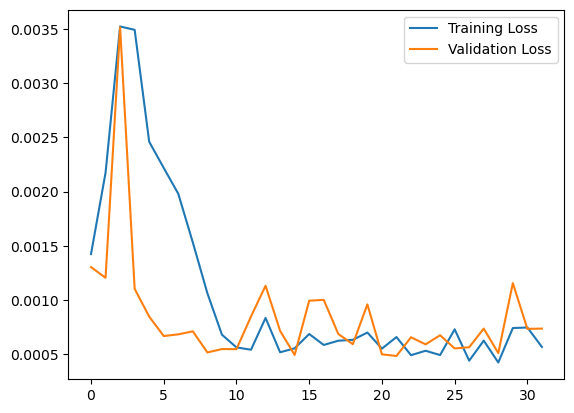

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

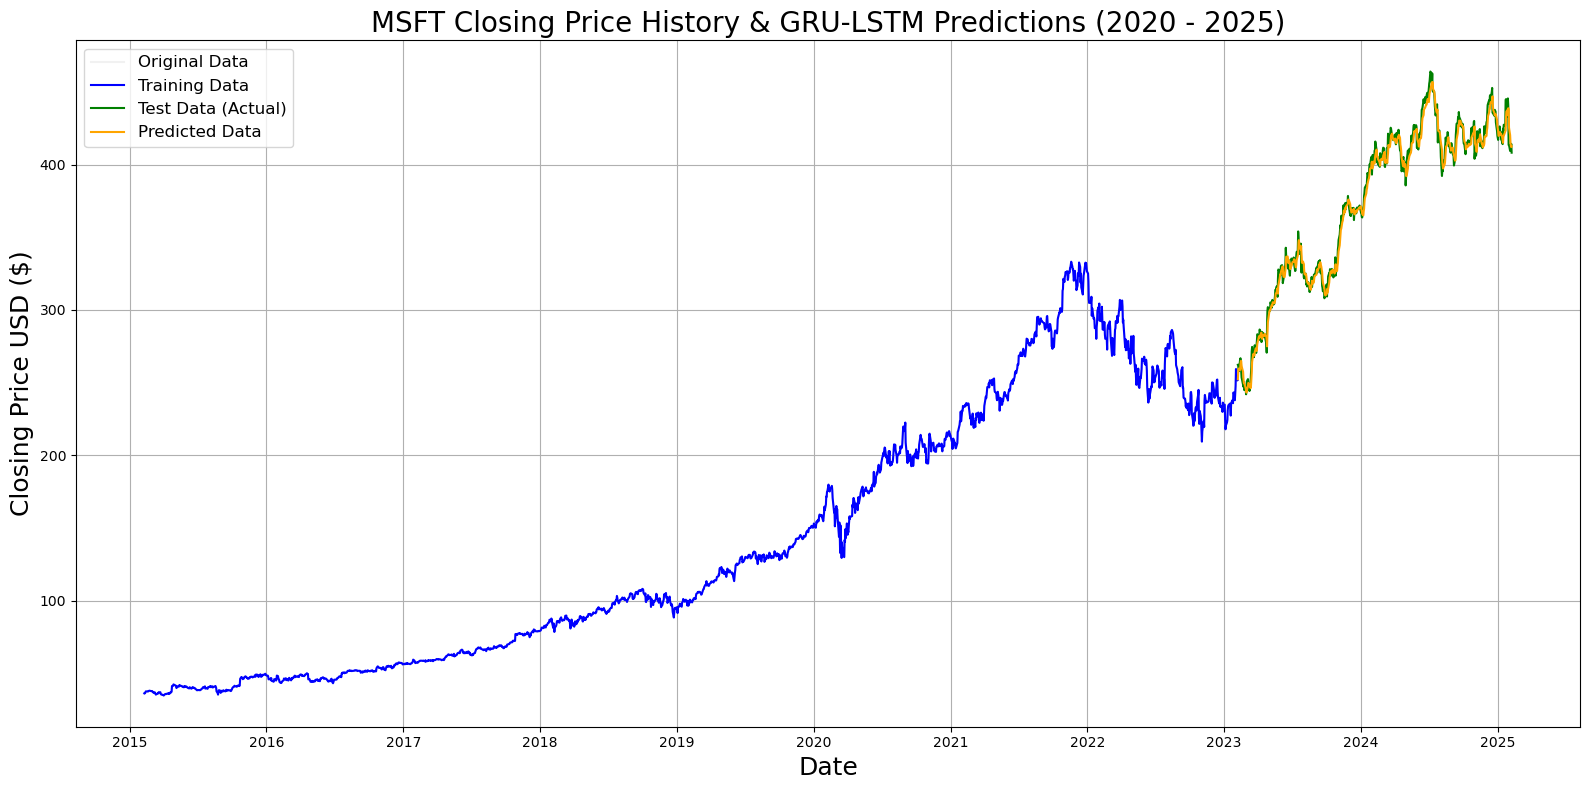

In [55]:
best_preds = best_result['preds']
y_test_actual = best_result['y_true']

# Create figure
plt.figure(figsize=(16, 8))
plt.title('MSFT Closing Price History & GRU-LSTM Predictions (2020 - 2025)', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)

# 0. Original reference: faded line
plt.plot(data_plot.index, data_plot['Close'], label='Original Data', color='lightgray', alpha=0.3)

# 1. Training data
train_dates = data_plot.index[:training_data_len]
plt.plot(train_dates, data_plot['Close'][:training_data_len], label='Training Data', color='blue')

# 2. Actual test data
test_dates = data_plot.index[training_data_len:]
plt.plot(test_dates, y_test_actual, label='Test Data (Actual)', color='green')

# 3. Predicted values
plt.plot(test_dates, best_preds, label='Predicted Data', color='orange')

# Final touch
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()